
# 压缩感知_断层重建

>翻译者:[@Loopy](https://github.com/loopyme)        
>校验者:[@barrycg](https://github.com/barrycg)

这个例子展示了从一组沿不同角度获得的平行投影来重建图像的过程。这样的数据集是在CT(计算机断层扫描)中获得的。

在没有任何样本得先验信息的情况下，重建图像所需的投影数与图像的线性大小l(以像素为单位)相同。为了简单起见，我们在这里考虑稀疏图像，其中只有对象边界上的像素具有非零值(例如:这些数据可以对应于细胞材料)。但是请注意，大多数图像在不同的基(basis)上是稀疏的，比如Haar小波 。只获得了l/7的投影，因此有必要利用关于样品的现有信息(稀疏性):这是压缩感知的一个例子。

层析投影操作是一种线性变换。除了线性回归对应的数据保真项外，我们还对图像的L1范数进行了惩罚，以解释其稀疏性。由此产生的优化问题称为Lasso。我们使用类sklearn.linear_model.Lasso,它是使用坐标下降算法实现的。重要的是，这种在稀疏阵上算法的计算效率比这里投影算子更高。

即使在投影中添加了噪声,L1罚项重建得到的结果也会是零误差(所有像素都被成功地标记为0或1)。相比之下，L2罚项(sklearn.linear_model.Ridge)会产生大量标记错误,也就是在重构图像上会观察到伪影，这与L1罚项相反。特别要注意的是，角落里分隔像素的圆形伪影所形成的投影比中央部分少。


In [ ]:
import numpy as np
from scipy import sparse
from scipy import ndimage
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt

In [ ]:
def _weights(x, dx=1, orig=0):
    x = np.ravel(x)
    floor_x = np.floor((x - orig) / dx).astype(np.int64)
    alpha = (x - orig - floor_x * dx) / dx
    return np.hstack((floor_x, floor_x + 1)), np.hstack((1 - alpha, alpha))

In [ ]:
def _generate_center_coordinates(l_x):
    X, Y = np.mgrid[:l_x, :l_x].astype(np.float64)
    center = l_x / 2.
    X += 0.5 - center
    Y += 0.5 - center
    return X, Y

In [ ]:
def build_projection_operator(l_x, n_dir):
    """ 计算层析矩阵

    参数
    ----------

    l_x : int
        图像阵列的线性大小

    n_dir : int
        投影的角度数

    Returns
    -------
    p : shape为(n_dir l_x, l_x**2)的稀疏矩阵
    """
    X, Y = _generate_center_coordinates(l_x)
    angles = np.linspace(0, np.pi, n_dir, endpoint=False)
    data_inds, weights, camera_inds = [], [], []
    data_unravel_indices = np.arange(l_x ** 2)
    data_unravel_indices = np.hstack((data_unravel_indices,
                                      data_unravel_indices))
    for i, angle in enumerate(angles):
        Xrot = np.cos(angle) * X - np.sin(angle) * Y
        inds, w = _weights(Xrot, dx=1, orig=X.min())
        mask = np.logical_and(inds >= 0, inds < l_x)
        weights += list(w[mask])
        camera_inds += list(inds[mask] + i * l_x)
        data_inds += list(data_unravel_indices[mask])
    proj_operator = sparse.coo_matrix((weights, (camera_inds, data_inds)))
    return proj_operator

In [ ]:
def generate_synthetic_data():
    """ 合成二进制数据 """
    rs = np.random.RandomState(0)
    n_pts = 36
    x, y = np.ogrid[0:l, 0:l]
    mask_outer = (x - l / 2.) ** 2 + (y - l / 2.) ** 2 < (l / 2.) ** 2
    mask = np.zeros((l, l))
    points = l * rs.rand(2, n_pts)
    mask[(points[0]).astype(np.int), (points[1]).astype(np.int)] = 1
    mask = ndimage.gaussian_filter(mask, sigma=l / n_pts)
    res = np.logical_and(mask > mask.mean(), mask_outer)
    return np.logical_xor(res, ndimage.binary_erosion(res))

In [ ]:
# 生成合成图像和投影
l = 128
proj_operator = build_projection_operator(l, l // 7)
data = generate_synthetic_data()
proj = proj_operator * data.ravel()[:, np.newaxis]
proj += 0.15 * np.random.randn(*proj.shape)

In [ ]:
# 用L2(岭)罚项重建
rgr_ridge = Ridge(alpha=0.2)
rgr_ridge.fit(proj_operator, proj.ravel())
rec_l2 = rgr_ridge.coef_.reshape(l, l)

In [ ]:
# 用L1(Lasso)罚项重建
# 采用交叉验证法确定最佳值
rgr_lasso = Lasso(alpha=0.001)
rgr_lasso.fit(proj_operator, proj.ravel())
rec_l1 = rgr_lasso.coef_.reshape(l, l)

In [ ]:
#画图
plt.figure(figsize=(8, 3.3))
plt.subplot(131)
plt.imshow(data, cmap=plt.cm.gray, interpolation='nearest')
plt.axis('off')
plt.title('原始图像')
plt.subplot(132)
plt.imshow(rec_l2, cmap=plt.cm.gray, interpolation='nearest')
plt.title('L2罚项')
plt.axis('off')
plt.subplot(133)
plt.imshow(rec_l1, cmap=plt.cm.gray, interpolation='nearest')
plt.title('L1罚项')
plt.axis('off')

plt.subplots_adjust(hspace=0.01, wspace=0.01, top=1, bottom=0, left=0,
                    right=1)

plt.show()

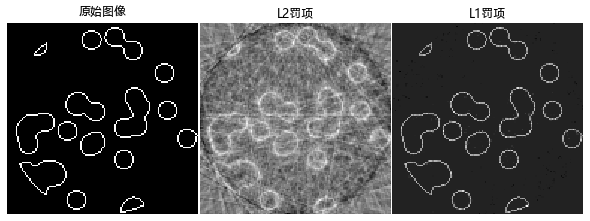